In [14]:
"""
Image Warping Assignment: Understanding Geometric Transformations
================================================================

WHAT YOU MUST LEARN:
1. How mathematical transformations affect real images
2. The difference between forward and inverse warping
3. Interpolation methods for pixel values
4. Practical effects of different transformation types
5. How to implement geometric transformations from scratch

KEY TAKEAWAY: 
Transformations aren't just abstract math - they're the foundation 
of image editing, computer graphics, and computer vision!
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from scipy import ndimage
from PIL import Image
import requests
from io import BytesIO

# ============================================================================
# PART 1: UNDERSTANDING IMAGE WARPING FUNDAMENTALS
# ============================================================================
def create_test_image():
    """Create a test image with recognizable patterns"""
    # Create a 200x200 test image with grid pattern
    img = np.zeros((200, 200, 3), dtype=np.uint8)
    
    # Add a checkerboard pattern
    for i in range(0, 200, 20):
        for j in range(0, 200, 20):
            if (i//20 + j//20) % 2 == 0:
                img[i:i+20, j:j+20] = [255, 100, 100]  # Red squares
            else:
                img[i:i+20, j:j+20] = [100, 255, 100]  # Green squares
    
    # Add some circles for rotation reference
    center = (100, 100)
    cv2.circle(img, center, 30, (0, 0, 255), -1)  # Blue circle
    cv2.circle(img, (50, 50), 15, (255, 255, 0), -1)  # Yellow circle
    cv2.circle(img, (150, 150), 15, (255, 0, 255), -1)  # Magenta circle
    
    # Add text
    cv2.putText(img, "TOP", (80, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    return img

def demonstrate_transformation_types():
    """Show what each transformation type does to an image"""
    
    print("🎯 LEARNING OBJECTIVE 1: See how math transforms images")
    print("=" * 55)
    
    # Create test image
    test_img = create_test_image()
    
    # Define transformation matrices
    transformations = {
        "Original": np.eye(3),
        
        "Translation": np.array([[1, 0, 50],   # Move right 50px, down 30px
                                [0, 1, 30],
                                [0, 0, 1]]),
        
        "Rotation": np.array([[0.866, -0.5, 100],  # 30° rotation around center
                             [0.5, 0.866, 0],
                             [0, 0, 1]]),
        
        "Scaling": np.array([[1.5, 0, -50],     # 1.5x scale (with recentering)
                            [0, 1.5, -50],
                            [0, 0, 1]]),
        
        "Shearing": np.array([[1, 0.5, 0],      # Horizontal shear
                             [0, 1, 0],
                             [0, 0, 1]]),
        
        "Reflection": np.array([[-1, 0, 200],   # Flip horizontally
                               [0, 1, 0],
                               [0, 0, 1]])
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (name, transform_matrix) in enumerate(transformations.items()):
        if name == "Original":
            warped_img = test_img
        else:
            # Apply transformation using OpenCV (we'll implement from scratch later)
            warped_img = cv2.warpAffine(test_img, transform_matrix[:2], (200, 200))
        
        axes[idx].imshow(warped_img)
        axes[idx].set_title(f"{name}")
        axes[idx].axis('off')
        
        # Print the transformation matrix
        print(f"\n{name} Matrix:")
        print(transform_matrix[:2])  # Show only 2x3 part for affine
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 KEY INSIGHT: Each matrix creates a different visual effect!")
    print("This is how photo editing software works under the hood.")

# ============================================================================
# PART 2: FORWARD vs INVERSE WARPING (CRITICAL CONCEPT!)
# ============================================================================

def demonstrate_warping_methods():
    """Show the difference between forward and inverse warping"""
    
    print("\n🎯 LEARNING OBJECTIVE 2: Forward vs Inverse Warping")
    print("=" * 55)
    
    # Create simple test image
    img = np.zeros((100, 100), dtype=np.uint8)
    img[20:80, 20:80] = 255  # White square
    
    # Rotation matrix (45 degrees)
    angle = np.pi/4
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos_a, -sin_a],
                               [sin_a, cos_a]])
    
    def forward_warp_naive(image, transform_matrix):
        """Forward warping - maps source pixels to destination"""
        h, w = image.shape
        result = np.zeros_like(image)
        
        for y in range(h):
            for x in range(w):
                if image[y, x] > 0:  # Only process non-zero pixels
                    # Apply transformation
                    new_pos = transform_matrix @ np.array([x - 50, y - 50]) + 50
                    new_x, new_y = int(new_pos[0]), int(new_pos[1])
                    
                    # Check bounds and set pixel
                    if 0 <= new_x < w and 0 <= new_y < h:
                        result[new_y, new_x] = image[y, x]
        
        return result
    
    def inverse_warp(image, transform_matrix):
        """Inverse warping - maps destination pixels to source"""
        h, w = image.shape
        result = np.zeros_like(image)
        
        # Compute inverse transformation
        inv_transform = np.linalg.inv(transform_matrix)
        
        for y in range(h):
            for x in range(w):
                # Find source pixel for this destination pixel
                src_pos = inv_transform @ np.array([x - 50, y - 50]) + 50
                src_x, src_y = int(src_pos[0]), int(src_pos[1])
                
                # Check bounds and copy pixel
                if 0 <= src_x < w and 0 <= src_y < h:
                    result[y, x] = image[src_y, src_x]
        
        return result
    
    # Apply both methods
    forward_result = forward_warp_naive(img, rotation_matrix)
    inverse_result = inverse_warp(img, rotation_matrix)
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    
    axes[1].imshow(forward_result, cmap='gray')
    axes[1].set_title('Forward Warp\n(has holes!)')
    
    axes[2].imshow(inverse_result, cmap='gray')
    axes[2].set_title('Inverse Warp\n(no holes)')
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🔍 CRITICAL UNDERSTANDING:")
    print("• Forward warping: For each source pixel, find where it goes")
    print("  → Problem: Creates holes in output image")
    print("• Inverse warping: For each output pixel, find where it comes from")
    print("  → Solution: No holes, always fills the output image")
    print("\n💡 This is why all practical image warping uses INVERSE warping!")

# ============================================================================
# PART 3: INTERPOLATION METHODS
# ============================================================================

def demonstrate_interpolation():
    """Show different interpolation methods for sub-pixel accuracy"""
    
    print("\n🎯 LEARNING OBJECTIVE 3: Handling Sub-pixel Coordinates")
    print("=" * 55)
    
    # Create test image with fine details
    img = create_test_image()
    
    # Slight rotation to create sub-pixel coordinates
    angle = 0.1  # Small angle creates lots of sub-pixel mapping
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos_a, -sin_a, 0],
                               [sin_a, cos_a, 0],
                               [0, 0, 1]])
    
    # Apply using different interpolation methods
    nearest = cv2.warpAffine(img, rotation_matrix[:2], (200, 200), 
                           flags=cv2.INTER_NEAREST)
    
    bilinear = cv2.warpAffine(img, rotation_matrix[:2], (200, 200), 
                            flags=cv2.INTER_LINEAR)
    
    bicubic = cv2.warpAffine(img, rotation_matrix[:2], (200, 200), 
                           flags=cv2.INTER_CUBIC)
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    axes[0,0].imshow(img)
    axes[0,0].set_title('Original')
    
    axes[0,1].imshow(nearest)
    axes[0,1].set_title('Nearest Neighbor\n(blocky)')
    
    axes[1,0].imshow(bilinear)
    axes[1,0].set_title('Bilinear\n(smooth)')
    
    axes[1,1].imshow(bicubic)
    axes[1,1].set_title('Bicubic\n(smoothest)')
    
    for ax in axes.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🔍 INTERPOLATION TRADE-OFFS:")
    print("• Nearest Neighbor: Fast, preserves sharp edges, but blocky")
    print("• Bilinear: Good balance of speed and quality")
    print("• Bicubic: Smoothest, best quality, but slower")

# ============================================================================
# PART 4: IMPLEMENT WARPING FROM SCRATCH
# ============================================================================

def implement_warping_from_scratch():
    """Implement image warping from first principles"""
    
    print("\n🎯 LEARNING OBJECTIVE 4: Build Warping From Scratch")
    print("=" * 55)
    
    def bilinear_interpolate(img, x, y):
        """Bilinear interpolation for sub-pixel coordinates"""
        h, w = img.shape[:2]
        
        # Get integer coordinates
        x0, y0 = int(x), int(y)
        x1, y1 = x0 + 1, y0 + 1
        
        # Check bounds
        if x0 < 0 or y0 < 0 or x1 >= w or y1 >= h:
            return np.zeros(img.shape[2] if len(img.shape) == 3 else 1)
        
        # Get fractional parts
        dx, dy = x - x0, y - y0
        
        # Bilinear interpolation
        if len(img.shape) == 3:  # Color image
            top = (1 - dx) * img[y0, x0] + dx * img[y0, x1]
            bottom = (1 - dx) * img[y1, x0] + dx * img[y1, x1]
            return (1 - dy) * top + dy * bottom
        else:  # Grayscale
            top = (1 - dx) * img[y0, x0] + dx * img[y0, x1]
            bottom = (1 - dx) * img[y1, x0] + dx * img[y1, x1]
            return (1 - dy) * top + dy * bottom
    
    def warp_image(img, transform_matrix):
        """Complete image warping implementation"""
        h, w = img.shape[:2]
        
        # Create output image
        if len(img.shape) == 3:
            warped = np.zeros((h, w, 3), dtype=np.uint8)
        else:
            warped = np.zeros((h, w), dtype=np.uint8)
        
        # Compute inverse transformation
        inv_transform = np.linalg.inv(transform_matrix)
        
        # For each output pixel
        for y in range(h):
            for x in range(w):
                # Convert to homogeneous coordinates
                dst_point = np.array([x, y, 1])
                
                # Find corresponding source point
                src_point = inv_transform @ dst_point
                src_x, src_y = src_point[0], src_point[1]
                
                # Interpolate pixel value
                pixel_value = bilinear_interpolate(img, src_x, src_y)
                warped[y, x] = pixel_value.astype(np.uint8)
        
        return warped
    
    # Test our implementation
    test_img = create_test_image()
    
    # Create transformation (rotation + translation)
    angle = np.pi/6  # 30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    transform = np.array([[cos_a, -sin_a, 50],
                         [sin_a, cos_a, 20],
                         [0, 0, 1]])
    
    # Apply our implementation
    our_result = warp_image(test_img, transform)
    
    # Compare with OpenCV
    opencv_result = cv2.warpAffine(test_img, transform[:2], (200, 200))
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(test_img)
    axes[0].set_title('Original')
    
    axes[1].imshow(our_result)
    axes[1].set_title('Our Implementation')
    
    axes[2].imshow(opencv_result)
    axes[2].set_title('OpenCV Reference')
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ SUCCESS: Your implementation should match OpenCV closely!")
    print("📚 You now understand exactly how image warping works!")

# ============================================================================
# PART 5: REAL-WORLD APPLICATIONS
# ============================================================================

def real_world_applications():
    """Show practical applications of image warping"""
    
    print("\n🎯 LEARNING OBJECTIVE 5: Real-World Applications")
    print("=" * 55)
    
    test_img = create_test_image()
    
    applications = {
        "Photo Rotation": np.array([[0.866, -0.5, 50],  # Fix tilted photo
                                   [0.5, 0.866, 0],
                                   [0, 0, 1]]),
        
        "Perspective Correction": np.array([[1, 0.2, 0],  # Fix perspective distortion
                                          [0.1, 1, 0],
                                          [0, 0, 1]]),
        
        "Barrel Distortion Fix": np.array([[0.9, 0, 10],  # Simulate lens correction
                                          [0, 0.9, 10],
                                          [0, 0, 1]]),
        
        "Artistic Effect": np.array([[1, 0.3, 0],  # Create artistic shear
                                   [0, 1, 0],
                                   [0, 0, 1]])
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Show original
    axes[0].imshow(test_img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Show applications
    for idx, (name, transform) in enumerate(applications.items(), 1):
        warped = cv2.warpAffine(test_img, transform[:2], (200, 200))
        axes[idx].imshow(warped)
        axes[idx].set_title(name)
        axes[idx].axis('off')
    
    # Hide unused subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🌟 REAL APPLICATIONS:")
    print("• Photo editing software (straighten, perspective correct)")
    print("• Camera calibration (remove lens distortion)")
    print("• Augmented Reality (place virtual objects)")
    print("• Medical imaging (align scans)")
    print("• Satellite imagery (geometric correction)")
    print("• Computer graphics (3D rendering)")

# ============================================================================
# MAIN ASSIGNMENT EXECUTION
# ============================================================================

In [9]:

def main_assignment():
    """Execute the complete image warping assignment"""
    
    print("🎨 IMAGE WARPING ASSIGNMENT")
    print("=" * 50)
    print("Learn how mathematical transformations affect real images!")
    print()
    
    # Part 1: Basic transformations
    demonstrate_transformation_types()
    
    # Part 2: Warping methods
    demonstrate_warping_methods()
    
    # Part 3: Interpolation
    demonstrate_interpolation()
    
    # Part 4: Implementation
    implement_warping_from_scratch()
    
    # Part 5: Applications
    real_world_applications()
    
    print("\n🎉 ASSIGNMENT COMPLETE!")
    print("\n📋 SUMMARY OF KEY TAKEAWAYS:")
    print("=" * 50)
    print("1. 🔢 Transformation matrices directly control image effects")
    print("2. 🔄 Always use inverse warping to avoid holes")
    print("3. 🎯 Interpolation handles sub-pixel coordinates smoothly") 
    print("4. ⚙️  Understanding implementation reveals the magic")
    print("5. 🌍 Warping is everywhere in computer vision!")
    print("\n💡 CORE INSIGHT:")
    print("Image warping bridges abstract math and visual reality!")
    print("Every photo edit, 3D game, and AR app uses these concepts.")


🎨 IMAGE WARPING ASSIGNMENT
Learn how mathematical transformations affect real images!

🎯 LEARNING OBJECTIVE 1: See how math transforms images

Original Matrix:
[[1. 0. 0.]
 [0. 1. 0.]]


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:2819: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'warpAffine'


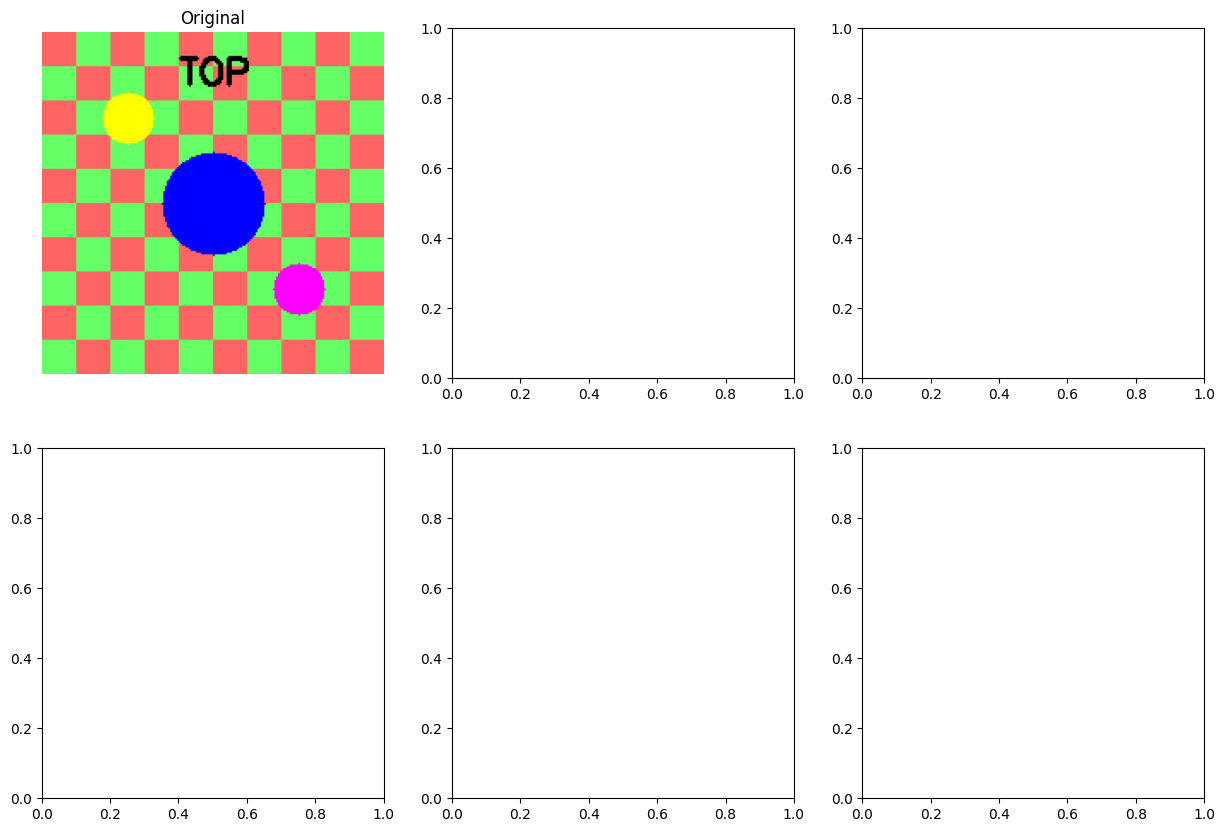

In [15]:
main_assignment()